1D CNN으로 스팸 메일 분류  
https://wikidocs.net/80787

In [1]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin-1')

In [3]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [5]:
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

In [6]:
data.drop_duplicates(subset=['v2'], inplace=True) # 중복 제거
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


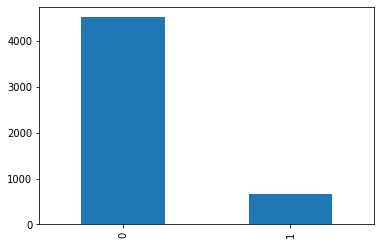

In [7]:
data['v1'].value_counts().plot(kind='bar')

In [8]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [9]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [10]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [11]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


메일의 최대 길이 : 172
메일의 평균 길이 : 12.566841


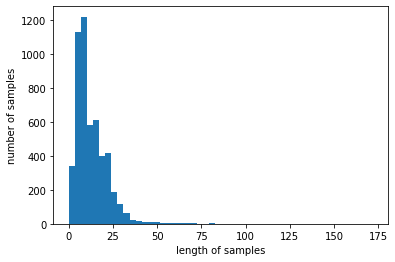

In [12]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
max_len = 172
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 172)


In [14]:
X_test = data[n_of_train:]  #X_data 뒤의 1034개
y_test = np.array(y_data[n_of_train:])  #y_data 뒤의 1034개
X_train = data[:n_of_train]  #X_data 앞의 4135개
y_train = np.array(y_data[:n_of_train])  #y_data 앞의 4135개
print("훈련용 이메일 데이터의 크기(shape): ", X_train.shape)
print("테스트용 이메일 데이터의 크기(shape): ", X_test.shape)
print("훈련용 레이블의 크기(shape): ", y_train.shape)
print("테스트용 레이블의 크기(shape): ", y_test.shape)

훈련용 이메일 데이터의 크기(shape):  (4135, 172)
테스트용 이메일 데이터의 크기(shape):  (1034, 172)
훈련용 레이블의 크기(shape):  (4135,)
테스트용 레이블의 크기(shape):  (1034,)


In [15]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [17]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [18]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=64, 
                    validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
52/52 [==============================] - 31s 18ms/step - loss: 0.4880 - acc: 0.8455 - val_loss: 0.3816 - val_acc: 0.8730

Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
Epoch 2/10
52/52 [==============================] - 0s 8ms/step - loss: 0.3732 - acc: 0.8697 - val_loss: 0.3447 - val_acc: 0.8730

Epoch 00002: val_acc did not improve from 0.87304
Epoch 3/10
52/52 [==============================] - 0s 8ms/step - loss: 0.2294 - acc: 0.9051 - val_loss: 0.1032 - val_acc: 0.9770

Epoch 00003: val_acc improved from 0.87304 to 0.97703, saving model to best_model.h5
Epoch 4/10
52/52 [==============================] - 0s 8ms/step - loss: 0.0587 - acc: 0.9852 - val_loss: 0.0572 - val_acc: 0.9831

Epoch 00004: val_acc improved from 0.97703 to 0.98307, saving model to best_model.h5
Epoch 5/10
52/52 [==============================] - 0s 8ms/step - loss: 0.0358 - acc: 0.9888 - val_loss: 0.0534 - val_acc: 0.9831

Epoch 00005: val_acc did not improve from

In [19]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 5ms/step - loss: 0.0566 - acc: 0.9778

 테스트 정확도: 0.9778


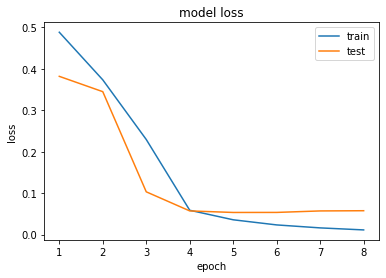

In [20]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()